In [22]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from diffusion_and_model import Diffusion_without_class,sample,p_losses
from torch import nn, einsum, optim
import torch
import tqdm
import os
# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline
timesteps =1000

In [3]:
model = Diffusion_without_class()

In [4]:

train_image = np.load("cifar10_train_image.npy")
train_label = np.load("cifar10_train_label.npy")
image_1000 = np.array(train_image[:1000])
labels_1000 =np.array(train_label[:1000])
train_image_transform = train_image/255.0*2-1

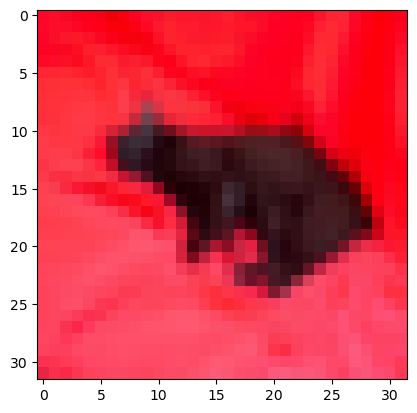

In [5]:

source = torch.tensor(train_image_transform[21:22].transpose([0,3,1,2]).astype(np.float32))
plt.imshow((source[0].numpy().transpose(1,2,0)+1.0)/2.0)

In [6]:
model.load_state_dict(torch.load('cifar10_diffusion_without_class_model_epoch_10000_dataset_1000_sample_1000_time.pth'))

<All keys matched successfully>

torch.Size([1, 3, 32, 32])


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000
torch.Size([1, 3, 32, 32])


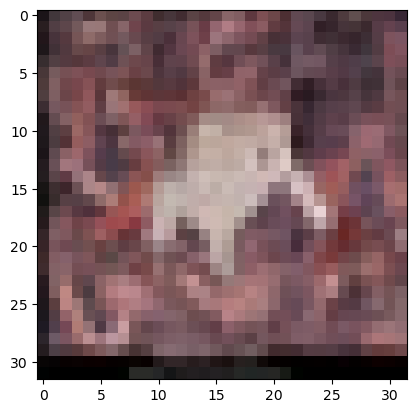

In [10]:
samples = sample(model, image_size=32, batch_size=1, channels=3)

# Get the last sample and normalize it in [0,1]
# last_sample = (samples[-1] - samples[-1].min())/(samples[-1].max()-samples[-1].min())
last_sample = samples[-1]
print(len(samples))
print(last_sample.shape)
plt.imshow((last_sample[0].numpy().transpose(1,2,0)+1.0)/2.0)

In [13]:
class generalized_inverse(nn.Module):
    def __init__(self):
        super().__init__()
        self.avgpool2d = nn.AvgPool2d(4)
        self.upsample = nn.Upsample(scale_factor=4)
        self.color2gray =  torch.tensor([1/3.0, 1/3.0, 1/3.0], requires_grad=False, dtype=torch.float32).reshape(
            1, 3).to("cuda")
        self.gray2color = torch.tensor([1.0, 1.0,1.0], requires_grad=False, dtype=torch.float32).reshape(
            3, 1).to("cuda")


#         self.w = nn.parameter.Parameter(torch.zeros((2,1000)))
        self.w = nn.parameter.Parameter(torch.zeros((1,3,32,32)))
 
    def forward(self,Pan,Ms):
        #B`Z + (Y-B`ZA)A` +(I-B`B)W(I-AA`)
 
        Bg_iZ=self.upsample(Ms)

        Bg_iZA = einsum('n m, k m w h -> k n w h', self.color2gray, Bg_iZ)

        Y_Bg_iZAAg_i = einsum('m n, k n w h -> k m w h',self.gray2color, Pan-Bg_iZA)
        
        Bg_iBW = self.upsample(self.avgpool2d(self.w))
        W_Bg_iBW = self.w - Bg_iBW
        
        AAg_i = einsum('n m, m c -> n c', self.color2gray, self.gray2color)
        
        W_Bg_iBW_AAg_i=einsum('n m, k n w h -> k m w h', AAg_i, W_Bg_iBW)
        return Bg_iZ + Y_Bg_iZAAg_i +W_Bg_iBW - W_Bg_iBW_AAg_i

    def direct(self,Pan,MS):
        #B`Z + (Y-B`ZA)A` 
        Bg_iZ=self.upsample(Ms)
        Bg_iZA = einsum('n m, k m w h -> k n w h', self.color2gray, Bg_iZ)
        Y_Bg_iZAAg_i = einsum('m n, k n w h -> k m w h',self.gray2color, Pan-Bg_iZA)
        return Bg_iZ + Y_Bg_iZAAg_i
    def test(self):
        return torch.sum(self.w)
    def A_(self,source):

        Pan = einsum('n m, k m w h -> k n w h',self.color2gray, source)
        Ms = self.avgpool2d(source)
        return Pan, Ms


In [14]:
device = "cuda"
model=model.to(device)
g_i =  generalized_inverse()
g_i = g_i.to("cuda")
source = source.to("cuda")
Pan, Ms=g_i.A_(source)
Pan=Pan.to("cuda")
Ms = Ms.to("cuda")
print("pan shape",Pan.shape)
print("ms shape",Ms.shape)

pan shape torch.Size([1, 1, 32, 32])
ms shape torch.Size([1, 3, 8, 8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


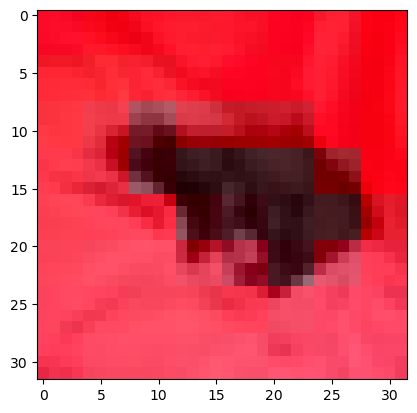

In [17]:
if not os.path.exists(r"figure\images_pansharpening\PCS"):
    os.makedirs( r"figure\images_pansharpening\PCS")
file_name = r"figure\images_pansharpening\PCS\1_recover.png"
signalx=g_i.direct(Pan,Ms)
plt.imshow((signalx[0].cpu().detach().numpy().transpose(1,2,0)+1)/2)

plt.imsave(file_name,np.clip((signalx[0].cpu().detach().numpy().transpose(1,2,0)+1)/2,0,1))

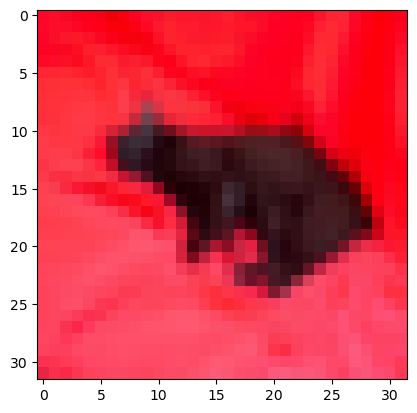

In [18]:
if not os.path.exists(r"figure\images_pansharpening\origin"):
    os.makedirs( r"figure\images_pansharpening\origin")
file_name = r"figure\images_pansharpening\origin\1_origin.png"
plt.imshow((source[0].cpu().numpy().transpose(1,2,0)+1.0)/2.0)
plt.imsave(file_name,(source[0].cpu().numpy().transpose(1,2,0)+1.0)/2.0)

In [23]:
opt_sgd = optim.SGD(g_i.parameters(), lr=1)
scaler = torch.cuda.amp.GradScaler()
#for p in model.parameters():
#    p.requires_grad = False
def train_generalized_inverse():
    iteration = 220001
    for i in range(iteration):

        opt_sgd.zero_grad()

        # Evaluate the loss
        #loss = g_i.loss(y)
        
        signal_x=g_i(Pan,Ms)
        t = torch.randint(0, timesteps, (1,), device="cuda").long()

        loss_diffusion = p_losses(model, signal_x, t)
  
        scaler.scale(loss_diffusion).backward()
        scaler.step(opt_sgd)

        scaler.update()
        if i%1000==0:
            print(f' iteration: {i}, loss: {loss_diffusion.item():g}')
train_generalized_inverse()


 iteration: 0, loss: 0.0364158
 iteration: 1000, loss: 0.00283526
 iteration: 2000, loss: 0.00139414
 iteration: 3000, loss: 0.000125376
 iteration: 4000, loss: 0.000585507
 iteration: 5000, loss: 0.000592113
 iteration: 6000, loss: 0.000504835
 iteration: 7000, loss: 0.000403299
 iteration: 8000, loss: 0.000329003
 iteration: 9000, loss: 0.00116995
 iteration: 10000, loss: 0.000244559
 iteration: 11000, loss: 0.000332996
 iteration: 12000, loss: 0.0056298
 iteration: 13000, loss: 0.000540606
 iteration: 14000, loss: 0.000366212
 iteration: 15000, loss: 0.000330868
 iteration: 16000, loss: 0.00220666
 iteration: 17000, loss: 0.00103339
 iteration: 18000, loss: 0.00115299
 iteration: 19000, loss: 0.00103333
 iteration: 20000, loss: 0.402057
 iteration: 21000, loss: 0.000591469
 iteration: 22000, loss: 0.000914281
 iteration: 23000, loss: 0.00301417
 iteration: 24000, loss: 0.000227929
 iteration: 25000, loss: 0.00050934
 iteration: 26000, loss: 0.00157669
 iteration: 27000, loss: 0.0020

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


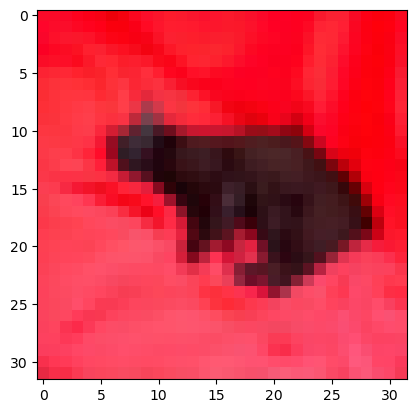

In [22]:
file_name = r"figure\images_pansharpening\ours\1_recover.png"

signal_x=g_i(Pan,Ms)
plt.imshow((signal_x[0].cpu().detach().numpy().transpose([1,2,0])+1)/2)
plt.imsave(file_name,np.clip((signal_x[0].cpu().detach().numpy().transpose([1,2,0])+1)/2,0,1))

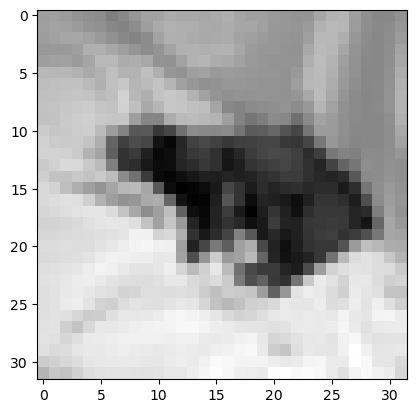

In [23]:
file_name = r"figure\images_pansharpening\origin\1_pan.png"
plt.imshow((Pan[0].cpu().detach().numpy().transpose([1,2,0])+1)/2,cmap='gray')
plt.imsave(file_name,(Pan[0,0].cpu().detach().numpy()+1)/2,cmap='gray')

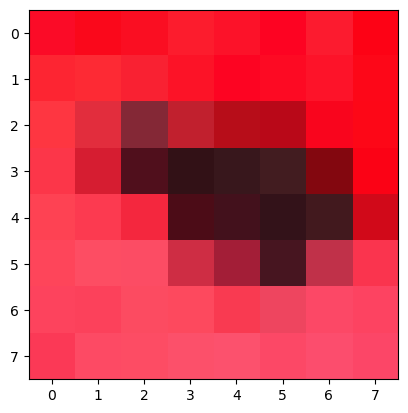

In [25]:
file_name = r"figure\images_pansharpening\origin\1_ms.png"
plt.imshow((Ms[0].cpu().detach().numpy().transpose([1,2,0])+1)/2,cmap='gray')
plt.imsave(file_name,(Ms[0].cpu().detach().numpy().transpose([1,2,0])+1)/2,cmap='gray')

In [26]:
# RMSE
np.sqrt(np.mean(((source[0].cpu().numpy().transpose(1,2,0)+1.0)/2.0-(signal_x[0].cpu().detach().numpy().transpose([1,2,0])+1)/2)**2))

0.009541747

In [27]:
#color consistency
np.sqrt(np.mean((((nn.AvgPool2d(4)(signal_x))[0].cpu().detach().numpy().transpose([1,2,0])+1)/2-(Ms[0].cpu().detach().numpy().transpose([1,2,0])+1)/2)**2))

3.434548e-08

In [28]:
#spatial consistency
color2gray=torch.tensor([1/3.0, 1/3.0, 1/3.0], requires_grad=False, dtype=torch.float32).reshape(
            1, 3).to("cuda")
np.sqrt(np.mean(((einsum('n m, k m w h -> k n w h',color2gray, signal_x)[0,0].cpu().detach().numpy()+1)/2-(Pan[0,0].cpu().detach().numpy()+1)/2)**2))

0.006492179

In [29]:
#PCS
signalx=g_i.direct(Pan,Ms)

In [30]:
# RMSE
np.sqrt(np.mean(((signalx[0].cpu().numpy().transpose(1,2,0)+1.0)/2.0-(signal_x[0].cpu().detach().numpy().transpose([1,2,0])+1)/2)**2))

0.052617542

In [31]:
#color consistency
np.sqrt(np.mean((((nn.AvgPool2d(4)(signalx))[0].cpu().detach().numpy().transpose([1,2,0])+1)/2-(Ms[0].cpu().detach().numpy().transpose([1,2,0])+1)/2)**2))

3.6436816e-08

In [32]:
#spatial consistency
color2gray=torch.tensor([1/3.0, 1/3.0, 1/3.0], requires_grad=False, dtype=torch.float32).reshape(
            1, 3).to("cuda")
np.sqrt(np.mean(((einsum('n m, k m w h -> k n w h',color2gray, signalx)[0,0].cpu().detach().numpy()+1)/2-(Pan[0,0].cpu().detach().numpy()+1)/2)**2))

2.3817107e-08